# Detectron2

1. 설치
    - 콘다 가상환경 진입
    - conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch
    - git clone https://github.com/facebookresearch/detectron2.git
    - pip install -e
    - pip install opencv-python

2. custom_dataset 실습
    - dectectron2_custom_dataset 폴더생성
    - train 300장 셋팅
    - 폴더에 train_test.ipynb 생성

- config_file_path, checkpoint_url 는 아래의 링크에서 선택 
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
- traian/val_path 경로 설정 및 레지스터 등록

In [ ]:
from detectron2.utils.logger import setup_logger

setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt


config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

output_dir = "./output/object_detection"
num_class = 2

device = "cuda"

train_dataset_name = "LP_train"
train_images_path = "/home/elicer/detectron2_custom_dataset/train"
train_json_annot_path = "/home/elicer/detectron2_custom_dataset/train.json"

test_dataset_name = "LP_test"
test_images_path = "/home/elicer/detectron2_custom_dataset/val"
test_json_annot_path = "/home/elicer/detectron2_custom_dataset/val.json"

cfg_svae_path = "IS_cfg.pikle"

if train_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(train_dataset_name)
    MetadataCatalog.remove(train_dataset_name)

if test_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(test_dataset_name)
    MetadataCatalog.remove(test_dataset_name)

register_coco_instances(name = train_dataset_name, metadata = {},
                        json_file = train_json_annot_path, image_root = train_images_path)

register_coco_instances(name = test_dataset_name, metadata = {},
                        json_file = test_json_annot_path, image_root = test_images_path)




 - 샘플 시각화로 train 데이터 확인

In [ ]:
dataset_custom = DatasetCatalog.get(train_dataset_name)
dataset_custom_metadata = MetadataCatalog.get(train_dataset_name)

for s in random.sample(dataset_custom, 3):
    image_path = s["file_name"].strip()  # 파일 경로의 공백 제거

        # 이미지 파일 존재 여부 확인
    if not os.path.exists(image_path):
        print(f"Image file does not exist: {image_path}")
        continue

    img = cv2.imread(image_path)
        
        # 이미지 로드 실패 처리
    if img is None:
        print(f"Failed to load image: {image_path}")
        continue
    v = Visualizer(img[:,:,::-1], metadata = dataset_custom_metadata, scale = 0.5)
    v= v.draw_dataset_dict(s)
    plt.figure(figsize=(15,20))
    plt.imshow(v.get_image())
    plt.show()

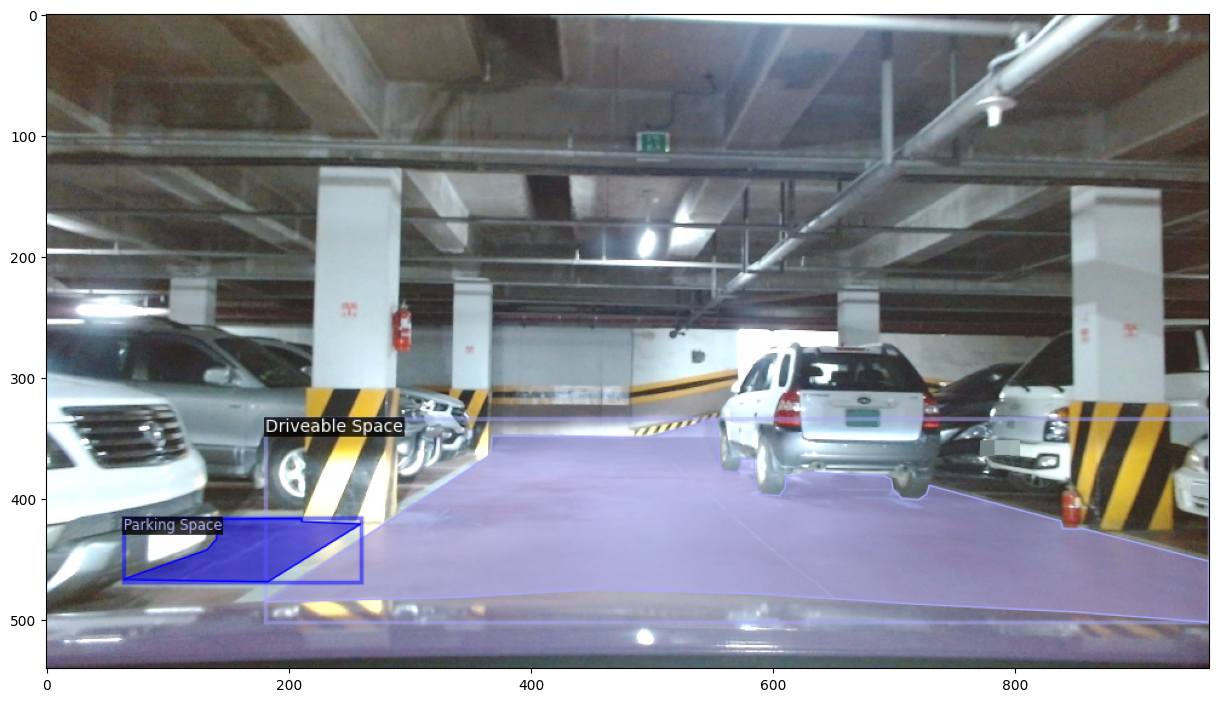

- 훈련 모델구현
- Iter =  (image dataset size / batch ) * epoch 로 설정

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
cfg.DATASETS.TRAIN = (train_dataset_name, )
cfg.DATASETS.TEST = (test_dataset_name, )

cfg.DATALOADER.NUM_WORKERS = 2  # 데이터 로딩 작업자 수 줄임

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # 학습률 낮춤
cfg.SOLVER.MAX_ITER = 1000  #  Iter =  (image dataset size / batch ) * epoch
cfg.SOLVER.STEPS = []

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True  # 그래디언트 클리핑 활성화
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0  # 클리핑 값 설정

cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_class
cfg.MODEL.DEVICE = "cuda"
cfg.OUTPUT_DIR = output_dir

with open(cfg_svae_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

trainer.train()

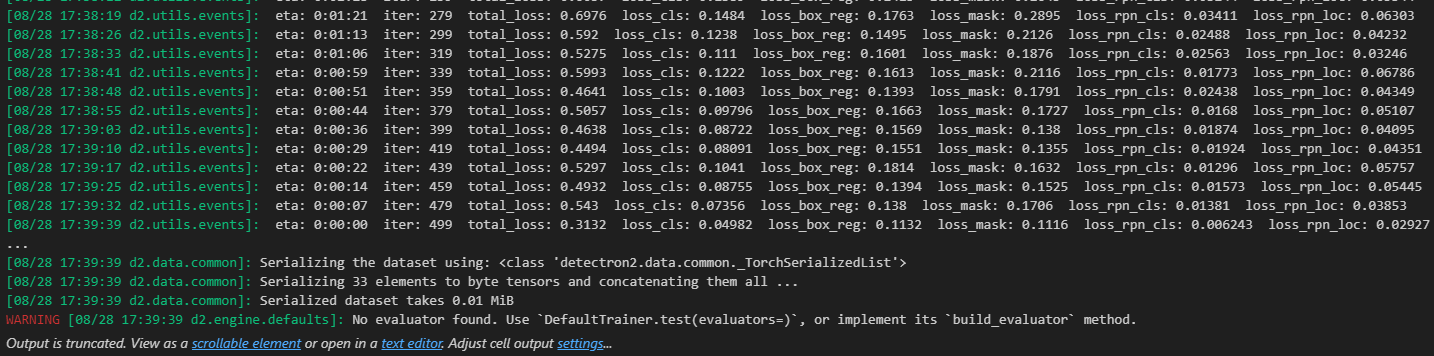

- tensorboard시각화
    - loss 확인

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=output

3. 지표 출력

In [ ]:
from detectron2.utils.logger import setup_logger

setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt



config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

output_dir = "./output_yolo/segmentation"
num_class = 4

device = "cuda"

test_dataset_name = "LP_test8"
test_images_path = "/home/elicer/new_val/shuffled_images"
test_json_annot_path = "/home/elicer/new_val/shuffled_labels_yolo_bbox_coco_bb.json"

cfg_svae_path = "IS_cfg_bbox.pikle"

if test_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(test_dataset_name)
    MetadataCatalog.remove(test_dataset_name)

# 새로운 데이터셋 등록
register_coco_instances(name=test_dataset_name, metadata={},
                        json_file=test_json_annot_path, image_root=test_images_path)

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
import numpy as np
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import torch

- 지표 함수

In [ ]:
def evaluate_model(predictor, dataset):
    pixel_accuracies = []
    ious_per_class = [[] for _ in range(2)]  # 두 클래스: "parking space"와 "driveable space"
    aps_per_class = [[] for _ in range(2)]
    aps_50_per_class = [[] for _ in range(2)]  # IoU 0.5 이상에서의 AP

    for i, data in enumerate(dataset):
        img = cv2.imread(data["file_name"])  # 이미지 로드
        annotations = data["annotations"]
        true_class_ids = np.array([anno["category_id"] for anno in annotations])  # Ground truth class IDs

        # 모델 예측 수행
        outputs = predictor(img)
        pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
        pred_class_ids = outputs["instances"].pred_classes.to("cpu").numpy()

        if len(pred_masks) > 0:
            pred_mask = pred_masks[0]  # 첫 번째 마스크 사용
        else:
            pred_mask = np.zeros((img.shape[0], img.shape[1]), dtype=bool)  # 빈 마스크 생성

        # 픽셀 정확도 계산 (여기서는 참고용, 실제 의미는 다를 수 있음)
        true_mask = np.zeros((img.shape[0], img.shape[1]), dtype=bool)
        pixel_accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        pixel_accuracies.append(pixel_accuracy)

        # 각 클래스별로 IoU 및 AP 계산 ("parking space" = 0, "driveable space" = 1)
        for class_id, class_name in enumerate(["parking space", "driveable space"]):
            true_class_mask = (true_class_ids == class_id).astype(int)  # 이진 값으로 변환
            pred_class_mask = (pred_class_ids == class_id).astype(int)  # 이진 값으로 변환

            # 길이 확인 후 조정
            if len(true_class_mask) != len(pred_class_mask):
                min_len = min(len(true_class_mask), len(pred_class_mask))
                true_class_mask = true_class_mask[:min_len]
                pred_class_mask = pred_class_mask[:min_len]

            # IoU 계산
            if len(pred_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                iou = jaccard_score(true_class_mask.flatten(), pred_class_mask.flatten(), average="binary")
                ious_per_class[class_id].append(iou)

                # IoU 0.5 이상일 때만 AP 계산
                if iou >= 0.5:
                    if np.sum(true_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                        precision, recall, _ = precision_recall_curve(true_class_mask.flatten(), pred_class_mask.flatten(), pos_label=1)
                        if len(recall) > 0 and len(precision) > 0:
                            ap = auc(recall, precision)
                            aps_50_per_class[class_id].append(ap)

            # 모든 IoU에서 AP 계산
            if np.sum(true_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                precision, recall, _ = precision_recall_curve(true_class_mask.flatten(), pred_class_mask.flatten(), pos_label=1)
                if len(recall) > 0 and len(precision) > 0:
                    ap = auc(recall, precision)
                    aps_per_class[class_id].append(ap)

    # 클래스별 IoU 및 AP 평균 계산
    mean_ious = [np.mean(iou_list) if len(iou_list) > 0 else 0 for iou_list in ious_per_class]
    mean_aps = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_per_class]
    mean_aps_50 = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_50_per_class]

    # mIoU 및 mAP 계산
    miou = np.mean(mean_ious)
    map_value = np.mean(mean_aps)
    map_50_value = np.mean(mean_aps_50)

    # 결과 출력
    print(f"Pixel Accuracy: {np.mean(pixel_accuracies)}")
    print(f"mIoU: {miou}")
    print(f"mAP: {map_value}")
    print(f"mAP@IoU 0.5: {map_50_value}")

    return {
        'pixel_accuracy': np.mean(pixel_accuracies),
        'class_iou': mean_ious,
        'class_ap': mean_aps,
        'class_ap_50': mean_aps_50,
        'miou': miou,
        'map': map_value,
        'map_50': map_50_value,
        'iou_per_class': ious_per_class,
        'aps_per_class': aps_per_class,
        'aps50_per_class': aps_50_per_class
    }


- 최종 지표 출력

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
import os

# 새로운 cfg 객체를 생성
cfg = get_cfg()

# 이전에 사용했던 모델 설정 파일을 로드 (여기서는 COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml 사용 예시)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# 훈련된 모델 가중치를 불러오기 (절대 경로를 사용해야 합니다)
cfg.MODEL.WEIGHTS = "/home/elicer/detectron2_custom_dataset/output_yolo2/segmentation/model_final.pth"

# 예측에 사용할 score threshold 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# 데이터셋의 클래스 수에 맞게 설정 (훈련 시 사용한 설정과 동일해야 함)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 예: 80 classes in COCO

# GPU가 여러 개라면 이를 설정 (기본적으로는 1)
cfg.MODEL.DEVICE = "cuda"  # 또는 "cpu"

# DefaultPredictor 객체 생성
predictor = DefaultPredictor(cfg)

# 평가 수행
dataset_val = DatasetCatalog.get(test_dataset_name)  # Validation dataset을 가져옵니다.
results1 = evaluate_model(predictor, dataset_val)


- epoch 당 지표 변화 출력

In [ ]:
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
import numpy as np 
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.roi_heads import FastRCNNOutputLayers, MaskRCNNConvUpsampleHead
from detectron2.modeling import build_model
import os

# 각 epoch마다 성능 지표를 저장할 리스트 초기화
pixel_accuracies = []
miou_values = []
map_values = []
map_50_values = []

# 설정
iterations_per_epoch = 4500
total_epochs = 10

# 기본적인 cfg 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # 클래스 수 설정
cfg.MODEL.DEVICE = "cuda"  # GPU 설정
dataset_val = DatasetCatalog.get(test_dataset_name)

# 10 epoch 동안 모델 평가
for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs}")

    # 매 epoch마다 새로운 모델 가중치 파일을 지정 (여기서는 가중치 파일명에 epoch 숫자를 포함)
    weight_file = f"/home/elicer/detectron2_custom_dataset/output_bbox/segmentation/model_{(epoch+1)*45000 - 1:07d}.pth"
    
    if not os.path.exists(weight_file):
        print(f"가중치 파일 {weight_file}을 찾을 수 없습니다. 스킵합니다.")
        continue

    # 새로운 모델 객체 생성 및 가중치 로드
    model = build_model(cfg)  # 모델 빌드
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(weight_file)  # 가중치만 로드
    model.eval()  # **평가 모드로 전환**

    # 새로 로드한 모델로 predictor 생성
    predictor = DefaultPredictor(cfg)
    predictor.model = model  # 로드한 가중치를 포함한 모델 사용

    # 한 epoch이 끝난 후 evaluate_model() 함수 호출하여 평가
    results = evaluate_model(predictor, dataset_val)

    # 각 지표 저장
    pixel_accuracies.append(results['pixel_accuracy'])
    miou_values.append(results['miou'])
    map_values.append(results['map'])
    map_50_values.append(results['map_50'])



print(results)

- 그래프 출력

In [ ]:
# 결과 시각화
epochs = range(1, total_epochs + 1)

# 하나의 그래프에 여러 지표 그리기
plt.figure(figsize=(10, 6))

# 각 지표를 하나의 그래프에 그리기
plt.plot(epochs, pixel_accuracies, label="Pixel Accuracy", marker='o')
plt.plot(epochs, miou_values, label="mIoU", marker='o', color='orange')
plt.plot(epochs, map_values, label="mAP", marker='o', color='green')
plt.plot(epochs, map_50_values, label="mAP@IoU 0.5", marker='o', color='red')

# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()

- 다른 모델과 지표 비교

In [ ]:
import matplotlib.pyplot as plt

# 데이터 준비
epochs = range(1, 11)

pixel_accuracies_batch2 =[0.9505, 0.9433, 0.9138, 0.9241, 0.9501, 0.9207, 0.9459, 0.9480, 0.9581, 0.9480]
map_50_values_batch2 =[0.9174, 0.9190, 0.9253, 0.9185, 0.9127, 0.9254, 0.9107, 0.9156, 0.9069, 0.9134]
map_values_batch2 =[0.3562, 0.3721, 0.4445, 0.4200, 0.3655, 0.4252, 0.3722, 0.3484, 0.3410, 0.3698]
miou_values_batch2 =[0.2090, 0.2270, 0.2987, 0.2720, 0.2193, 0.2824, 0.2255, 0.2029, 0.1927, 0.2223]

pixel_accuracies_batch16 =[0.9333, 0.9233, 0.9377, 0.9492, 0.9418, 0.9350, 0.9300, 0.9341, 0.9403, 0.9333]
map_50_values_batch16 =[0.9230, 0.9189, 0.9163, 0.9153, 0.9172, 0.9180, 0.9194, 0.9166, 0.9140, 0.9197]
map_values_batch16 =[0.3875, 0.4191, 0.3736, 0.3580, 0.3864, 0.3957, 0.4215, 0.4001, 0.3761, 0.3955]
miou_values_batch16 =[0.2380, 0.2752, 0.2301, 0.2158, 0.2380, 0.2500, 0.2760, 0.2582, 0.2317, 0.2521]

# 그래프 생성
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Pixel Accuracies
axs[0, 0].plot(epochs, pixel_accuracies_batch2, label="batch_size=2", marker='o')
axs[0, 0].plot(epochs, pixel_accuracies_batch16, label="batch_size=16", marker='s')
axs[0, 0].set_title('Pixel Accuracies')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_ylim(0.8, 1.0)
axs[0, 0].legend()

# mAP@50
axs[0, 1].plot(epochs, map_50_values_batch2, label="batch_size=2", marker='o')
axs[0, 1].plot(epochs, map_50_values_batch16, label="batch_size=16", marker='s')
axs[0, 1].set_title('mAP@50')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('mAP@50')
axs[0, 1].set_ylim(0.8, 1.0)
axs[0, 1].legend()

# mAP
axs[1, 0].plot(epochs, map_values_batch2, label="batch_size=2", marker='o')
axs[1, 0].plot(epochs, map_values_batch16, label="batch_size=16", marker='s')
axs[1, 0].set_title('mAP')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('mAP')
axs[1, 0].set_ylim(0.0, 0.5)
axs[1, 0].legend()

# mIoU
axs[1, 1].plot(epochs, miou_values_batch2, label="batch_size=2", marker='o')
axs[1, 1].plot(epochs, miou_values_batch16, label="batch_size=16", marker='s')
axs[1, 1].set_title('mIoU')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('mIoU')
axs[1, 1].set_ylim(0.0, 0.5)
axs[1, 1].legend()

plt.tight_layout()
plt.show()
